In [7]:
import os
import gzip
from datetime import datetime, timedelta, date
import pandas as pd
from time import sleep
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pickle
from sklearn.metrics import classification_report,accuracy_score
import warnings
from sklearn.ensemble import RandomForestClassifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer, Activation
from keras.utils import np_utils
from keras.metrics import Recall

%matplotlib inline

In [13]:
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    df = pickle.load(f)


df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df.head()


,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


##### データセットをohlcv形式にする。

In [23]:
FREQ = "15min"

time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = df["price"].resample(FREQ).ohlc()
volume = df["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)

ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)
time_bar.head()


,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


<AxesSubplot:xlabel='timestamp'>

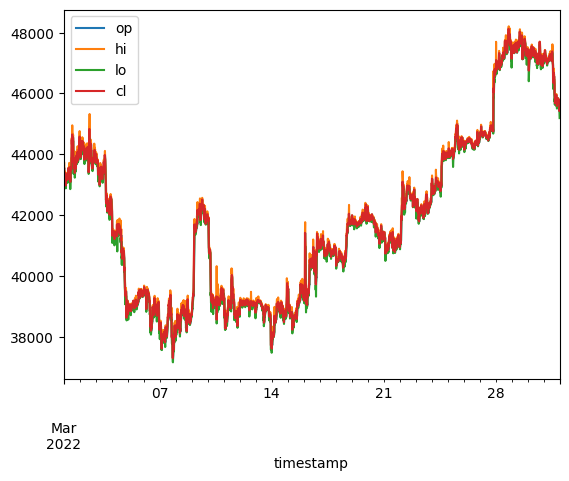

In [29]:
time_bar[["op", "hi", "lo", "cl"]].plot()

##### 固定時間ホライズン法を用いたラベリング

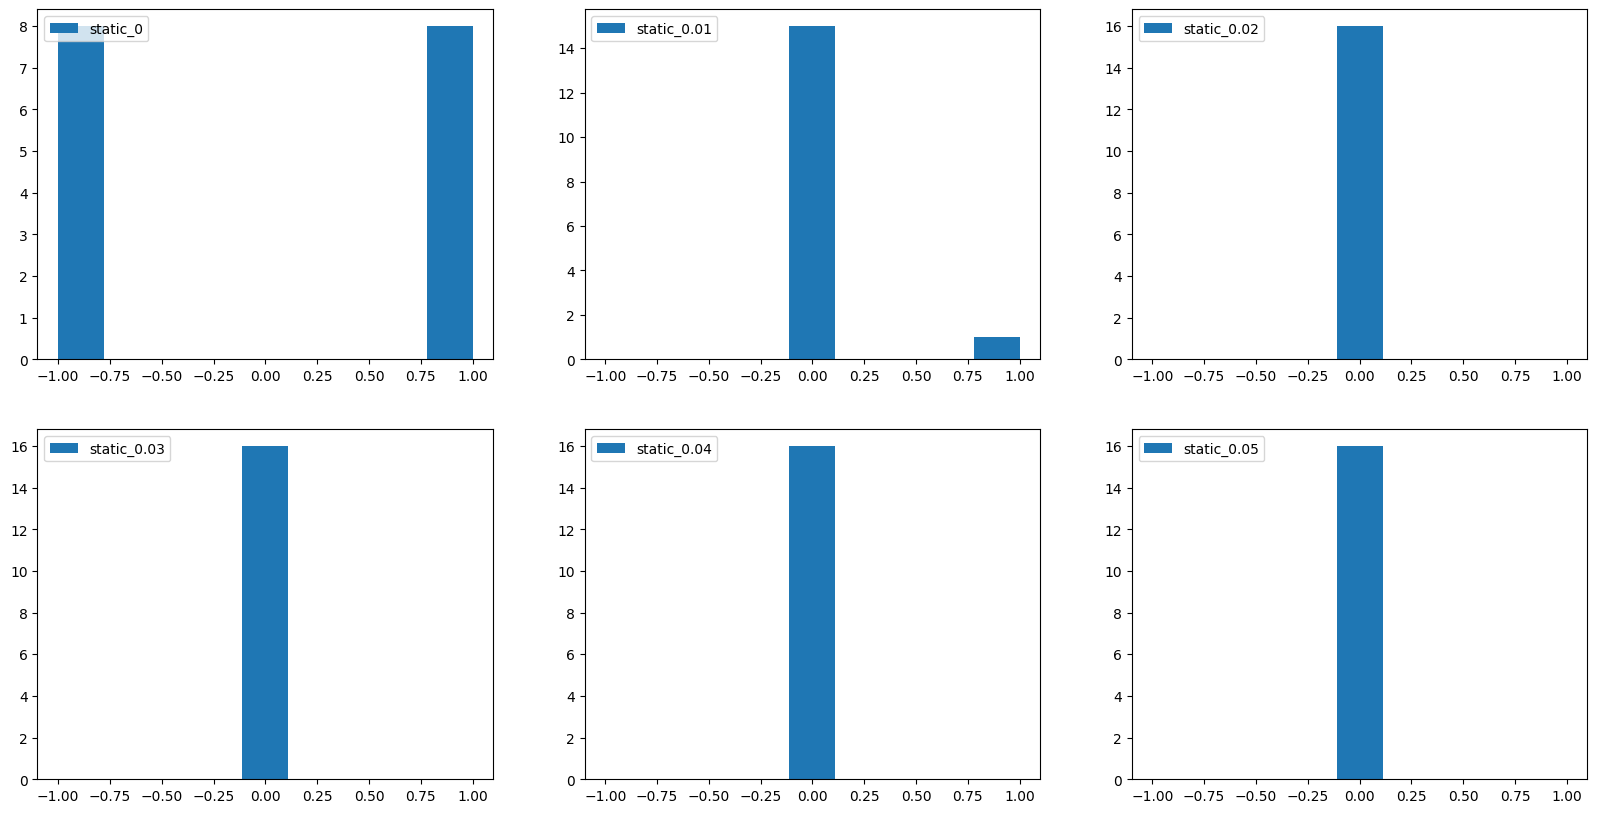

In [31]:
h = 16
returns = (time_bar["cl"].diff(h).shift(-h)[:h]/
           time_bar["cl"][:h].rename('r'))

fig = plt.figure(figsize=(20,10))
thre_r = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
for i, r in enumerate(thre_r):
    labels_static = returns.apply(lambda x: x/abs(x) if abs(x) > r else 0)
    ax = fig.add_subplot(2, 3, i+1)
    bins = np.linspace(-1, 1, 10)
    ax.hist(labels_static, bins, label=f'static_{r}')
    ax.legend(loc='upper left')

plt.show()

#### 練習としてMNISTでロジスティック回帰をする


In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)